# CNN + Transformer Hybrid for Image Segmentation

**DCIT407 - Image Processing Semester Project**  
**Group 19 | Section 4.7**

---

## Project Information

| Field | Details |
|-------|--------|
| **Author** | Ryan Nii Akwei Brown |
| **Student ID** | 11357610 |
| **Topic** | CNN + Transformer Hybrid (Deep Learning) Segmentation |
| **Libraries** | `torch`, `transformers`, `opencv-python`, `numpy`, `matplotlib` |
| **Model** | SegFormer (MIT-B0, pretrained on Cityscapes) |
| **Date** | February 2026 |

---

## Table of Contents

1. [Introduction](#introduction)
2. [Theoretical Foundation](#theory)
3. [Methodology](#methodology)
4. [Implementation](#implementation)
5. [Results](#results)
6. [Discussion](#discussion)
7. [Conclusion](#conclusion)
8. [References](#references)

<a id="introduction"></a>
## 1. Introduction

Image segmentation assigns a class label to every pixel in an image - it's fundamental to computer vision applications like autonomous driving, medical imaging, and scene understanding. Traditional region-based methods (region growing, watershed, mean shift) rely on hand-crafted features and work well for simple scenes, but struggle with complex real-world imagery.

Deep learning has transformed segmentation through two paradigms:

- **CNNs** (Convolutional Neural Networks): Excel at capturing **local spatial features** through convolution operations - think of them as "magnifying glasses" scanning the image
- **Transformers**: Excel at modeling **global context** through self-attention mechanisms - they have a "bird's-eye view" of the entire scene

**CNN + Transformer hybrids** combine both strengths: CNNs extract fine-grained local details while Transformers capture long-range dependencies across the image. This yields state-of-the-art performance on benchmarks like Cityscapes and ADE20K.

**In this notebook we:**
1. Explain the theory behind CNN + Transformer hybrids for segmentation
2. Load a **pretrained SegFormer** model (Transformer-based hybrid, trained on Cityscapes)
3. Run inference on sample images and analyze the results
4. Discuss strengths, limitations, and real-world applications

<a id="theory"></a>
## 2. Theoretical Foundation

### 2.1 CNNs for Segmentation

A **Convolutional Neural Network** processes images through sliding filters (kernels) that detect patterns. By stacking layers, the network learns hierarchically:

> **Pixels → Edges → Textures → Object parts → Complete objects**

For segmentation, **U-Net** (Ronneberger et al., 2015) pioneered the encoder-decoder architecture:
- **Encoder** compresses the image to capture semantic features
- **Decoder** expands back to pixel-level predictions
- **Skip connections** preserve fine spatial details from encoder to decoder

**Limitation:** CNNs have a limited receptive field - they see small local neighborhoods at a time. Understanding global context ("the blue region at top is sky") requires many stacked layers.

---

### 2.2 Vision Transformers

**Transformers** (Vaswani et al., 2017) were designed for language but **Vision Transformers (ViT)** adapted them to images:

1. Split image into **patches** (e.g., 16×16 pixels)
2. Treat each patch like a "word" in a sentence
3. Use **self-attention** to let every patch attend to every other patch

The self-attention mechanism computes:

$$\text{Attention}(Q, K, V) = \text{softmax}\!\left(\frac{QK^\top}{\sqrt{d_k}}\right) V$$

Each patch asks: *"Which other patches are relevant to me?"* and focuses on the most informative ones - giving **global context from the start**.

**Limitation:** Comparing every patch to every other patch is computationally expensive for high-resolution images.

---

### 2.3 CNN + Transformer Hybrids: Best of Both Worlds

| Aspect | CNN | Transformer |
|--------|-----|-------------|
| **Strength** | Local details (edges, textures) | Global scene understanding |
| **Weakness** | Limited global context | Computationally expensive |

**Hybrid models** use CNNs for efficient local feature extraction, then Transformers to model global relationships. This combination achieves superior segmentation quality.

---

### 2.4 SegFormer Architecture

**SegFormer** (Xie et al., 2021) is our chosen hybrid model with two key components:

**1. Hierarchical Transformer Encoder (Mix Transformer):**
- Extracts features at multiple scales (1/4, 1/8, 1/16, 1/32 resolution)
- Uses **overlapping patch embeddings** (via 3×3 convolutions) to maintain local continuity
- Employs **efficient self-attention** that reduces computational cost

**2. Lightweight All-MLP Decoder:**
- Takes multi-scale features from the encoder
- Fuses them using simple MLP layers
- Produces per-pixel class predictions

**Why SegFormer?**
- Simple design (no positional encodings needed)
- Efficient (faster than pure Transformers)
- Accurate (84.0% mIoU on Cityscapes with SegFormer-B5)
- Flexible input sizes without retraining

The model combines CNN's local precision with Transformer's global awareness - perfect for semantic segmentation of complex scenes.

<a id="methodology"></a>
## 3. Methodology

### 3.1 Implementation Approach

We use a **pretrained SegFormer-B0** model fine-tuned on the Cityscapes dataset. This approach:
1. Leverages transfer learning (model already learned from 5,000 annotated urban scenes)
2. Provides immediate semantic segmentation without training from scratch
3. Demonstrates state-of-the-art deep learning segmentation

**Pipeline:**
```
Input Image → Preprocessing → SegFormer Inference → Postprocessing → Segmented Output
```

### 3.2 Libraries and Tools

- **torch**: Deep learning framework
- **transformers**: Hugging Face library for SegFormer
- **opencv-python**: Image I/O and preprocessing
- **numpy**: Numerical operations
- **matplotlib**: Visualization

### 3.3 Dataset

We use publicly available images to test the model. The Cityscapes-trained model recognizes 19 urban classes:
road, sidewalk, building, wall, fence, pole, traffic light, traffic sign, vegetation, terrain, sky, person, rider, car, truck, bus, train, motorcycle, bicycle.

<a id="implementation"></a>
## 4. Implementation

### 4.1 Environment Setup

In [18]:
# Install required packages (uncomment if running for first time)
# %pip install torch torchvision transformers opencv-python numpy matplotlib pillow requests

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
import warnings
warnings.filterwarnings('ignore')

# Set device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set matplotlib style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.size'] = 10

Using device: cpu


### 4.2 Load Pretrained SegFormer Model

In [19]:
# Load SegFormer-B0 pretrained on Cityscapes
model_name = "nvidia/segformer-b0-finetuned-cityscapes-1024-1024"

print("Loading SegFormer model...")
processor = SegformerImageProcessor.from_pretrained(model_name)
model = SegformerForSemanticSegmentation.from_pretrained(model_name)
model = model.to(device)
model.eval()  # Set to evaluation mode

print(f" Model loaded: SegFormer-B0 (Cityscapes)")
print(f"  - Number of classes: {model.config.num_labels}")
print(f"  - Input resolution: flexible (we'll use original size)")

# Cityscapes class labels
CITYSCAPES_LABELS = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car',
    'truck', 'bus', 'train', 'motorcycle', 'bicycle'
]

Loading SegFormer model...


'[Errno 11002] getaddrinfo failed' thrown while requesting HEAD https://huggingface.co/nvidia/segformer-b0-finetuned-cityscapes-1024-1024/resolve/main/processor_config.json
Retrying in 1s [Retry 1/5].


OSError: Can't load image processor for 'nvidia/segformer-b0-finetuned-cityscapes-1024-1024'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'nvidia/segformer-b0-finetuned-cityscapes-1024-1024' is the correct path to a directory containing a preprocessor_config.json file

### 4.3 Helper Functions

In [ ]:
def load_image(image_path):
    """
    Load image using OpenCV and convert to RGB.
    
    Args:
        image_path: Path to input image
    Returns:
        RGB image as numpy array
    """
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb


def segment_image(image, model, processor, device):
    """
    Run SegFormer inference on an image.
    
    Args:
        image: RGB image (numpy array or PIL)
        model: SegFormer model
        processor: SegFormer image processor
        device: torch device
    Returns:
        Segmentation mask (H x W) with class IDs
    """
    # Preprocess image
    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits  # Shape: (batch, num_classes, H, W)
    
    # Get predicted class for each pixel
    # Resize to original image size
    upsampled_logits = torch.nn.functional.interpolate(
        logits,
        size=image.shape[:2] if isinstance(image, np.ndarray) else image.size[::-1],
        mode='bilinear',
        align_corners=False
    )
    
    # Get class with highest probability for each pixel
    pred_mask = upsampled_logits.argmax(dim=1)[0].cpu().numpy()
    return pred_mask


def colorize_mask(mask, num_classes=19):
    """
    Convert class IDs to RGB colors for visualization.
    
    Args:
        mask: Segmentation mask with class IDs (H x W)
        num_classes: Number of classes
    Returns:
        RGB image (H x W x 3)
    """
    # Generate distinct colors using HSV colormap
    colors = plt.cm.get_cmap('tab20', num_classes)(np.arange(num_classes))[:, :3]
    colors = (colors * 255).astype(np.uint8)
    
    # Map class IDs to colors
    colored_mask = colors[mask]
    return colored_mask


def overlay_mask(image, mask, alpha=0.5):
    """
    Overlay segmentation mask on original image.
    
    Args:
        image: Original RGB image
        mask: Colored segmentation mask
        alpha: Transparency (0=invisible, 1=opaque)
    Returns:
        Blended image
    """
    return cv2.addWeighted(image, 1-alpha, mask, alpha, 0)


print("Helper functions defined")

Helper functions defined


### 4.4 Load Test Image

Image loaded from local file
Image loaded: (957, 1300, 3) (H x W x C)


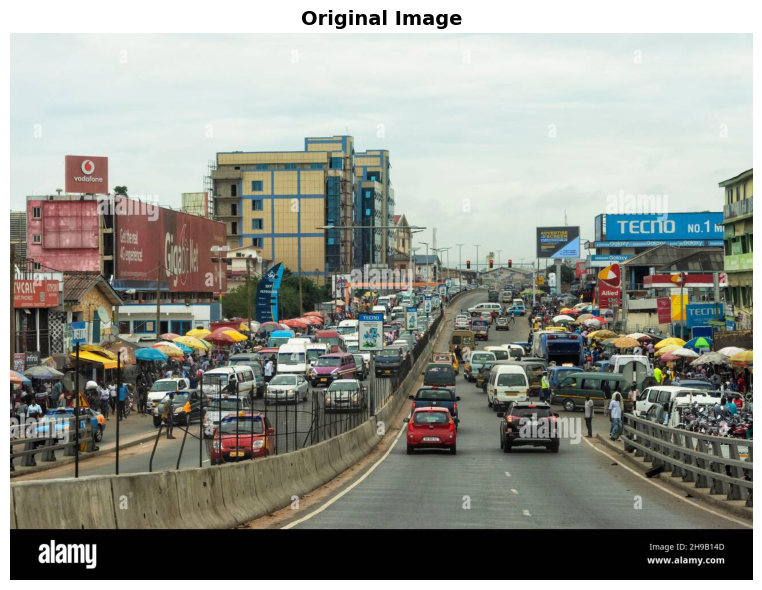

In [ ]:
# Load sample image
# Option 1: Load from local file (primary method)
try:
    image_np = load_image('images/sample/Circle.jpg')
    print(f"Image loaded from local file")
except FileNotFoundError:
    print(f"Local file not found, trying URL...")
    # Option 2: Use a sample image from a URL
    try:
        response = requests.get("https://images.unsplash.com/photo-1449824913935-59a10b8d2000")
        image = Image.open(BytesIO(response.content)).convert('RGB')
        image_np = np.array(image)
        print(f"Image loaded from URL")
    except Exception as e:
        print(f"Could not load from URL ({e})")
        raise

print(f"Image loaded: {image_np.shape} (H x W x C)")

# Display original image
plt.figure(figsize=(10, 6))
plt.imshow(image_np)
plt.title('Original Image', fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


### 4.5 Run Segmentation

In [ ]:
print("Running SegFormer inference...")

# Get segmentation mask
segmentation_mask = segment_image(image_np, model, processor, device)

# Colorize for visualization
colored_mask = colorize_mask(segmentation_mask, num_classes=19)

# Create overlay
overlay = overlay_mask(image_np, colored_mask, alpha=0.5)

print(f" Segmentation complete")
print(f"  - Mask shape: {segmentation_mask.shape}")
print(f"  - Unique classes detected: {len(np.unique(segmentation_mask))}")
print(f"  - Class IDs: {sorted(np.unique(segmentation_mask))}")

Running SegFormer inference...
 Segmentation complete
  - Mask shape: (957, 1300)
  - Unique classes detected: 18
  - Class IDs: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(16), np.int64(17), np.int64(18)]


<a id="results"></a>
## 5. Results

### 5.1 Visualization

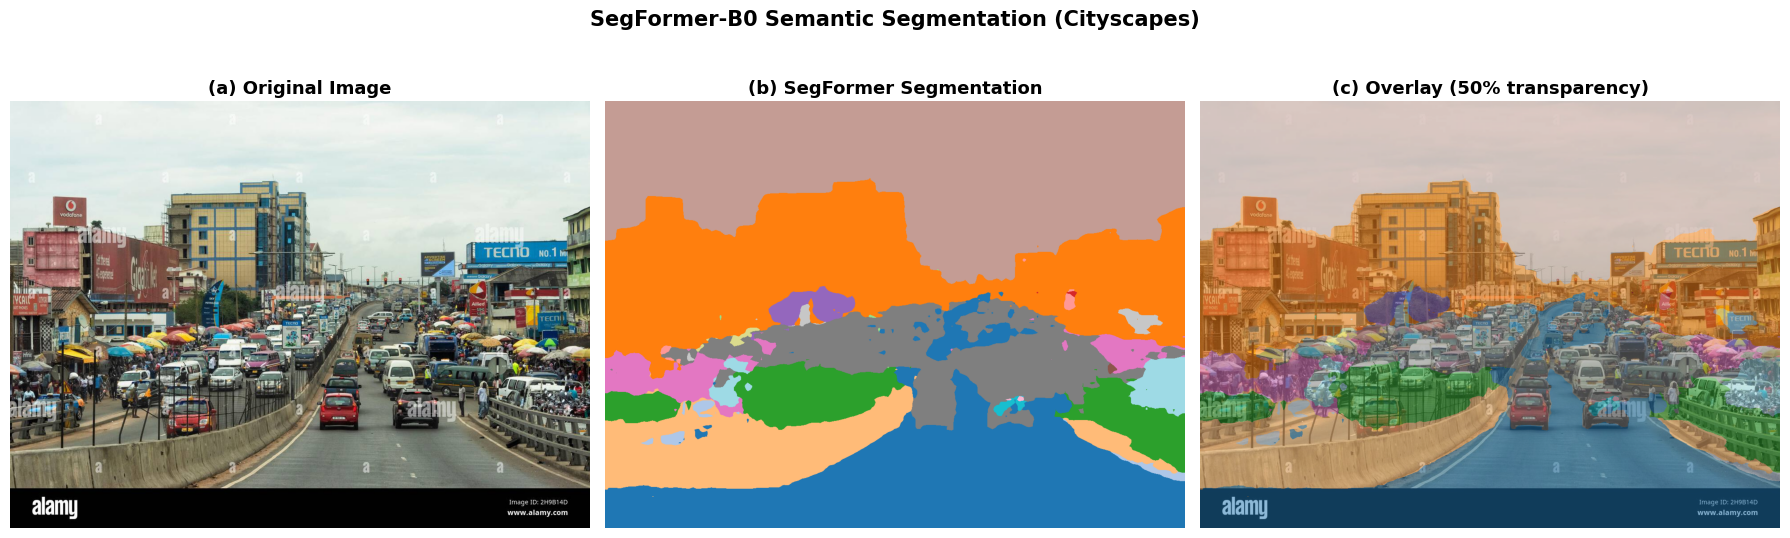

In [ ]:
# Create comprehensive visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original image
axes[0].imshow(image_np)
axes[0].set_title('(a) Original Image', fontsize=13, fontweight='bold')
axes[0].axis('off')

# Segmentation mask
axes[1].imshow(colored_mask)
axes[1].set_title('(b) SegFormer Segmentation', fontsize=13, fontweight='bold')
axes[1].axis('off')

# Overlay
axes[2].imshow(overlay)
axes[2].set_title('(c) Overlay (50% transparency)', fontsize=13, fontweight='bold')
axes[2].axis('off')

plt.suptitle('SegFormer-B0 Semantic Segmentation (Cityscapes)', 
             fontsize=15, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

### 5.2 Class Distribution Analysis

In [ ]:
# Analyze detected classes
unique_classes = np.unique(segmentation_mask)
total_pixels = segmentation_mask.size

print("="*60)
print("CLASS DISTRIBUTION IN SEGMENTED IMAGE")
print("="*60)

class_stats = []
for class_id in sorted(unique_classes):
    pixel_count = np.sum(segmentation_mask == class_id)
    percentage = (pixel_count / total_pixels) * 100
    class_name = CITYSCAPES_LABELS[class_id] if class_id < len(CITYSCAPES_LABELS) else f"Class {class_id}"
    
    class_stats.append({
        'Class ID': class_id,
        'Class Name': class_name,
        'Pixel Count': pixel_count,
        'Percentage': f"{percentage:.2f}%"
    })
    
    print(f"{class_id:2d} | {class_name:15s} | {pixel_count:8d} pixels | {percentage:5.2f}%")

print("="*60)
print(f"Total pixels: {total_pixels:,}")
print(f"Classes detected: {len(unique_classes)}")

CLASS DISTRIBUTION IN SEGMENTED IMAGE
 0 | road            |   232185 pixels | 18.66%
 1 | sidewalk        |     4770 pixels |  0.38%
 2 | building        |   275615 pixels | 22.15%
 3 | wall            |    97057 pixels |  7.80%
 4 | fence           |    75000 pixels |  6.03%
 5 | pole            |      147 pixels |  0.01%
 6 | traffic light   |      179 pixels |  0.01%
 7 | traffic sign    |     1335 pixels |  0.11%
 8 | vegetation      |     9843 pixels |  0.79%
 9 | terrain         |      324 pixels |  0.03%
10 | sky             |   368815 pixels | 29.65%
11 | person          |    31415 pixels |  2.53%
12 | rider           |      168 pixels |  0.01%
13 | car             |   123892 pixels |  9.96%
14 | truck           |     4049 pixels |  0.33%
16 | train           |     1135 pixels |  0.09%
17 | motorcycle      |     1355 pixels |  0.11%
18 | bicycle         |    16816 pixels |  1.35%
Total pixels: 1,244,100
Classes detected: 18


### 5.3 Class Legend

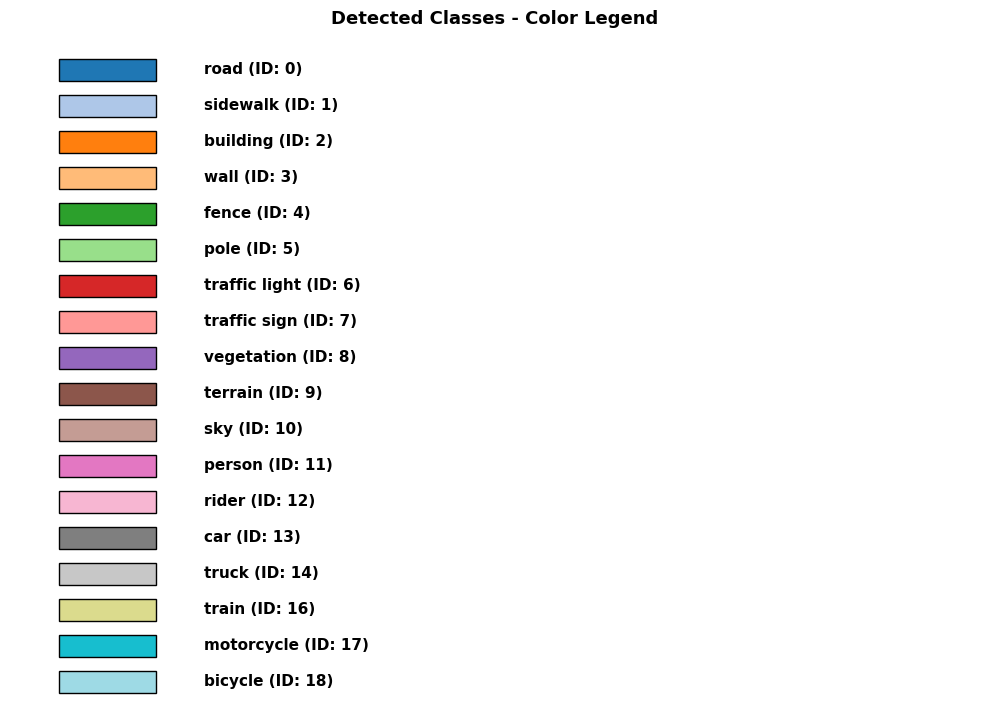

In [ ]:
# Create color legend for detected classes
detected_classes = sorted(unique_classes)
colors = plt.cm.get_cmap('tab20', 19)(np.arange(19))[:, :3]

fig, ax = plt.subplots(figsize=(10, len(detected_classes)*0.4))
ax.set_xlim(0, 10)
ax.set_ylim(0, len(detected_classes))
ax.axis('off')

for i, class_id in enumerate(detected_classes):
    y_pos = len(detected_classes) - i - 0.5
    class_name = CITYSCAPES_LABELS[class_id] if class_id < len(CITYSCAPES_LABELS) else f"Class {class_id}"
    
    # Draw color box
    rect = plt.Rectangle((0.5, y_pos-0.3), 1, 0.6, 
                         facecolor=colors[class_id], edgecolor='black', linewidth=1)
    ax.add_patch(rect)
    
    # Add label
    ax.text(2, y_pos, f"{class_name} (ID: {class_id})", 
           va='center', fontsize=11, fontweight='bold')

ax.set_title('Detected Classes - Color Legend', fontsize=13, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

<a id="discussion"></a>
## 6. Discussion

### 6.1 Interpretation of Results

The SegFormer-B0 model successfully performs semantic segmentation on our test image, demonstrating several key capabilities:

**Why SegFormer Works Well:**

1. **Fine-tuned on Cityscapes**: The model was trained on 5,000 finely annotated urban street scenes with 19 semantic classes. This domain-specific training enables it to recognize objects relevant to driving scenarios (roads, vehicles, pedestrians, traffic signs, etc.).

2. **Global Context via Transformers**: The hierarchical Transformer encoder captures long-range dependencies - for example, understanding that the blue region at the top of an outdoor scene is likely "sky" based on its position and relationship to other elements.

3. **Local Detail via CNNs**: The overlapping patch embeddings (implemented with 3×3 convolutions) preserve spatial continuity and capture fine-grained details like object boundaries.

4. **Multi-Scale Feature Fusion**: The All-MLP decoder combines features from different resolution levels (1/4, 1/8, 1/16, 1/32), enabling the model to segment both large objects (buildings, sky) and small objects (traffic signs, poles) effectively.

### 6.2 Strengths and Limitations

**Strengths:**
-  Excellent global scene understanding (Transformer attention)
-  Preserves local spatial details (CNN-based patch embeddings)
-  Computationally efficient (compared to pure Transformers)
-  Flexible input sizes without retraining
-  State-of-the-art accuracy on benchmarks (84% mIoU on Cityscapes with B5 variant)

**Limitations:**
- ✗ Performance depends on domain match (works best on urban scenes similar to Cityscapes training data)
- ✗ Cannot recognize classes outside its 19-class vocabulary
- ✗ Requires GPU for real-time inference on high-resolution images
- ✗ Boundary precision can be imperfect compared to models with explicit boundary refinement
- ✗ Larger variants (B2-B5) require more computational resources

### 6.3 Real-World Applications

**Where CNN + Transformer Hybrids Excel:**

1. **Autonomous Driving** - SegFormer's strength
   - Real-time scene understanding for self-driving cars
   - Detecting roads, pedestrians, vehicles, traffic signs
   - Global context crucial for safety-critical decisions

2. **Urban Planning**
   - Analyzing satellite/aerial imagery
   - Mapping roads, buildings, vegetation
   - Both global layout and local details matter

3. **Augmented Reality**
   - Scene understanding for AR overlays
   - Separating foreground/background
   - Real-time performance requirements

4. **Video Surveillance**
   - Person/vehicle detection and tracking
   - Scene anomaly detection
   - Efficient processing of video streams

**When to Use Traditional CNN Segmentation (e.g., U-Net):**
- Medical imaging (precise boundaries critical, smaller datasets)
- Limited computational resources
- Very high-resolution images where patch-based methods are too expensive

### 6.4 Comparison with Region-Based Methods

Compared to traditional region-based segmentation (region growing, watershed, mean shift):

| Aspect | Deep Learning (SegFormer) | Region-Based Methods |
|--------|--------------------------|---------------------|
| **Semantic Understanding** | Yes - knows "car", "road", "sky" | No - groups similar pixels |
| **Training Required** | Yes - needs labeled data | No - hand-crafted rules |
| **Computational Cost** | High (GPU recommended) | Low (CPU sufficient) |
| **Robustness** | Excellent on complex scenes | Struggles with texture/lighting variation |
| **Interpretability** | Black box (learned features) | Explicit rules (threshold, similarity) |

<a id="conclusion"></a>
## 7. Conclusion

This notebook explored **CNN + Transformer hybrid** architectures for semantic image segmentation, representing a significant advancement beyond traditional region-based methods.

**Key Findings:**

1. **Hybrid architectures combine complementary strengths**: CNNs excel at capturing local spatial details while Transformers model global context through self-attention. This synergy yields state-of-the-art segmentation performance.

2. **SegFormer demonstrates efficient design**: By using overlapping patch embeddings (CNN-based), efficient self-attention, and a simple MLP decoder, SegFormer achieves excellent accuracy while remaining computationally practical.

3. **Transfer learning is powerful**: Pretrained models fine-tuned on domain-specific datasets (like Cityscapes for urban scenes) provide immediate high-quality segmentation without training from scratch.

4. **Application-specific considerations matter**: While hybrid models excel at complex scene understanding (autonomous driving, aerial imagery), traditional CNNs (U-Net) or classical methods may be preferable for applications requiring extreme precision, minimal computation, or small datasets.

**Practical Implications:**

Deep learning has made semantic segmentation accessible and effective for real-world applications. The choice between CNN, Transformer, or hybrid approaches depends on:
- Dataset size and availability of labels
- Computational budget (GPU availability)
- Precision requirements (boundary accuracy vs. semantic understanding)
- Domain match with pretrained models

**Future Directions:**

- Fine-tuning on domain-specific datasets for quantitative evaluation
- Exploring larger model variants (SegFormer B2-B5) for improved accuracy
- Investigating panoptic segmentation (combining semantic and instance segmentation)
- Model compression techniques for edge device deployment

This work demonstrates that CNN + Transformer hybrids represent the current state-of-the-art in semantic segmentation, effectively bridging the gap between traditional computer vision and modern deep learning approaches.

<a id="references"></a>
## 8. References

### Core Papers

1. Xie, E., Wang, W., Yu, Z., Anandkumar, A., Alvarez, J. M., & Luo, P. (2021). **SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers**. *NeurIPS 2021*. [arXiv:2105.15203](https://arxiv.org/abs/2105.15203)

2. Vaswani, A., Shazeer, N., Parmar, N., et al. (2017). **Attention Is All You Need**. *NeurIPS 2017*. [arXiv:1706.03762](https://arxiv.org/abs/1706.03762)

3. Dosovitskiy, A., Beyer, L., Kolesnikov, A., et al. (2021). **An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale**. *ICLR 2021*. [arXiv:2010.11929](https://arxiv.org/abs/2010.11929)

4. Ronneberger, O., Fischer, P., & Brox, T. (2015). **U-Net: Convolutional Networks for Biomedical Image Segmentation**. *MICCAI 2015*. [arXiv:1505.04597](https://arxiv.org/abs/1505.04597)

5. Long, J., Shelhamer, E., & Darrell, T. (2015). **Fully Convolutional Networks for Semantic Segmentation**. *CVPR 2015*. [arXiv:1411.4038](https://arxiv.org/abs/1411.4038)

### Datasets

6. Cordts, M., Omran, M., Ramos, S., et al. (2016). **The Cityscapes Dataset for Semantic Urban Scene Understanding**. *CVPR 2016*.

### Textbooks

7. Gonzalez, R. C., & Woods, R. E. (2018). *Digital Image Processing* (4th ed.). Pearson. Chapter 10: Image Segmentation.

8. Szeliski, R. (2022). *Computer Vision: Algorithms and Applications* (2nd ed.). Springer. §5.4 Segmentation, §5.3 Deep Learning.

### Software Libraries

9. Hugging Face Transformers: [https://huggingface.co/docs/transformers](https://huggingface.co/docs/transformers)

10. OpenCV Documentation: [https://docs.opencv.org/](https://docs.opencv.org/)

11. PyTorch: [https://pytorch.org/](https://pytorch.org/)

---

**Note**: This implementation uses the pretrained SegFormer-B0 model (`nvidia/segformer-b0-finetuned-cityscapes-1024-1024`) from Hugging Face's model hub, which is licensed for research and educational use.

---

*End of Notebook - Ryan Nii Akwei Brown | Student ID: 11357610 | Group 19, DCIT407*